In [1]:
import glob
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import PyWGCNA
import plotly.express as px
import math

from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from matplotlib import pyplot as plt


In [2]:
def MA_plot_df(results_df):
    mod = results_df.copy(deep=True)
    mod.loc[mod['padj'] <= 0.05, 'sig'] = 'P<0.05' 
    mod['sig'] = mod['sig'].fillna('Non-significant')
    
    return mod


In [3]:
def make_MA_plot(MA_df,title):
    fig = px.scatter(data_frame=MA_df,x='baseMean', 
           y='log2FoldChange',
           color='sig',
           log_x=True,
           color_discrete_sequence=['red','grey'],
           opacity=0.5)

    fig.update_layout(
        title=title,
        xaxis_title='mean of normalized counts', 
     #   yaxis_range=([-2,2]),
        )
    fig.show()

In [70]:
def plotDispEsts(dds):
    '''
    Params
        dds: a DESeqDataSet with dispersions estimated

    '''
    plt.rcParams.update({'font.size': 6})

    plt.figure(figsize=(3,3),dpi=300)
    plt.scatter(x=dds.varm['_normed_means'],y=dds.varm['genewise_dispersions'],c='black',alpha=0.5,s=0.4)
    plt.scatter(x=dds.varm['_normed_means'],y=dds.varm['dispersions'],c='royalblue',alpha=0.5,s=0.4) 
    plt.scatter(x=dds.varm['_normed_means'],y=dds.varm['fitted_dispersions'],c='red',alpha=0.5,s=0.4) 

    plt.yscale('log')
    plt.xscale('log')
    plt.legend(['Estimated','Final','Fitted'],loc='best')
    plt.xlabel('mean of normalized counts')
    plt.ylabel('dispersion')
    plt.show()
    

In [4]:
data = pd.read_table('/Users/erin/git/DS_public_data/03_pydeseq/data/Mov10_full_counts.txt',index_col=[0])
meta = pd.read_table('/Users/erin/git/DS_public_data/03_pydeseq/meta/Mov10_full_meta.txt',index_col=[0])

In [5]:
data.head()

,Mov10_kd_2,Mov10_kd_3,Mov10_oe_1,Mov10_oe_2,Mov10_oe_3,Irrel_kd_1,Irrel_kd_2,Irrel_kd_3
GeneSymbol,,,,,,,,
1/2-SBSRNA4,57,41,64,55,38,45,31,39
A1BG,71,40,100,81,41,77,58,40
A1BG-AS1,256,177,220,189,107,213,172,126
A1CF,0,1,1,0,0,0,0,0
A2LD1,146,81,138,125,52,91,80,50


In [6]:
meta.head()

,sampletype,MOVexpr
Mov10_kd_2,MOV10_knockdown,low
Mov10_kd_3,MOV10_knockdown,low
Mov10_oe_1,MOV10_overexpression,high
Mov10_oe_2,MOV10_overexpression,high
Mov10_oe_3,MOV10_overexpression,high


In [7]:
counts = data.T.reindex(meta.index)

In [8]:
counts.head()

GeneSymbol,1/2-SBSRNA4,A1BG,A1BG-AS1,A1CF,A2LD1,A2M,A2ML1,A2MP1,A4GALT,A4GNT,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,tAKR
Mov10_kd_2,57,71,256,0,146,10,3,0,56,0,...,6771,308,1155,4578,1072,4628,5296,4353,3401,1
Mov10_kd_3,41,40,177,1,81,9,2,0,37,0,...,4121,204,602,2778,678,2817,2982,2358,2006,1
Mov10_oe_1,64,100,220,1,138,2,6,2,107,0,...,4603,362,1027,4478,991,3406,3244,2482,2514,0
Mov10_oe_2,55,81,189,0,125,5,5,1,118,0,...,4293,317,945,3911,920,3072,3485,1991,2236,0
Mov10_oe_3,38,41,107,0,52,2,2,3,65,1,...,2561,219,592,2412,588,2049,1596,1114,1466,0


In [47]:
genes_to_keep = counts.columns[counts.sum(axis=0) >= 10]
counts = counts[genes_to_keep]

In [48]:
#R
#dds <- DESeqDataSetFromMatrix(countData = data, colData = meta, design = ~ sampletype)

dds = DeseqDataSet(
    counts=counts,
    clinical=meta,
    design_factors=['sampletype'],
    refit_cooks=True,
    n_cpus=8,
)

In [49]:
#r
#dds <- DESeq(dds)

dds.deseq2()

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 7.63 seconds.

Fitting dispersion trend curve...
... done in 4.20 seconds.

Fitting MAP dispersions...
... done in 8.24 seconds.

Fitting LFCs...
... done in 7.82 seconds.

Refitting 0 outliers.



In [11]:
#dds.layers['normed_counts'] after running .deseq2() are the same as the DESEQ2 normalized counts in R 
normdf = pd.DataFrame(data=dds.layers['normed_counts'],columns=counts.columns, index=counts.index)
normdf.head()

GeneSymbol,1/2-SBSRNA4,A1BG,A1BG-AS1,A1CF,A2LD1,A2M,A2ML1,A2MP1,A4GALT,A4GNT,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,tAKR
Mov10_kd_2,36.429341,45.376898,163.612478,0.000000,93.310241,6.391112,1.917334,0.000000,35.790230,0.000000,...,4327.422214,196.846262,738.173483,2925.851262,685.127250,2957.806824,3384.733133,2782.051233,2173.617331,0.639111
Mov10_kd_3,43.842016,42.772698,189.269189,1.069317,86.614714,9.623857,2.138635,0.000000,39.564746,0.000000,...,4406.657227,218.140761,643.729107,2970.563886,724.997234,3012.267267,3188.704647,2521.450556,2145.050812,1.069317
Mov10_oe_1,53.261952,83.221799,183.087958,0.832218,114.846083,1.664436,4.993308,1.664436,89.047325,0.000000,...,3830.699421,301.262913,854.687879,3726.672172,824.728031,2834.534484,2699.715169,2065.565058,2092.196034,0.000000
Mov10_oe_2,49.081233,72.283271,168.660966,0.000000,111.548258,4.461930,4.461930,0.892386,105.301555,0.000000,...,3831.013367,282.886382,843.304829,3490.121891,820.995178,2741.409984,3109.965428,1776.740651,1995.375236,0.000000
Mov10_oe_3,58.148548,62.739223,163.734070,0.000000,79.571698,3.060450,3.060450,4.590675,99.464622,1.530225,...,3918.906106,335.119265,905.893172,3690.902588,899.772273,3135.430930,2442.239026,1704.670598,2243.309782,0.000000


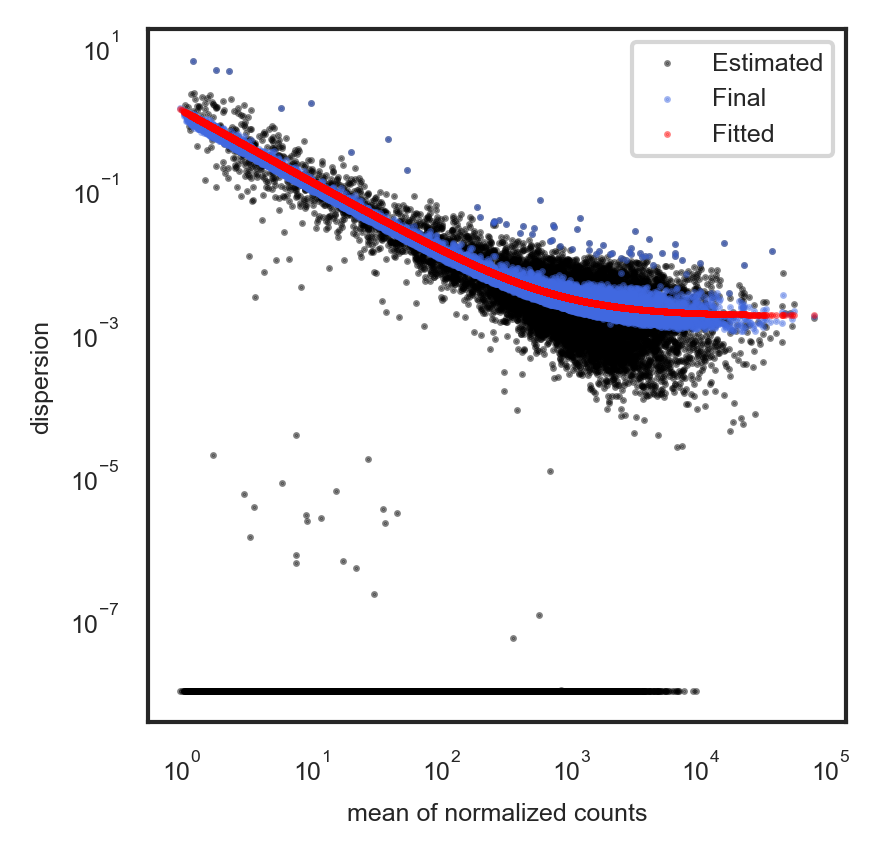

In [71]:
#Each black dot is a gene with an associated mean expression level 
#and maximum likelihood estimation (MLE) of the dispersion (Step 1).

#PyDESeq2 --> dds.varm['genewise_dispersions'] are MLE

plotDispEsts(dds)

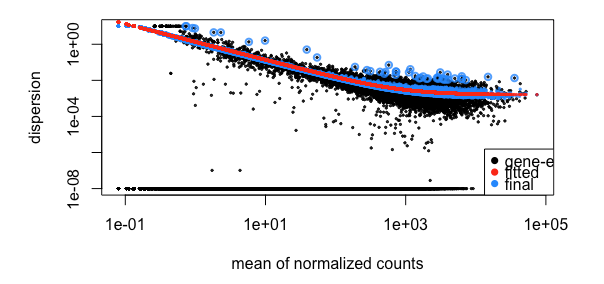